In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

import pdb

# Parameters
true_A = 1.
A = theano.shared(true_A, name="A")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=-1, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value A=0
p1s = []
p1_params = [(0,-1),(1,-1),(0,1)]
for p1_p in p1_params:
    p1s.append(LinearTransform(Join(components=[
        Normal(mu=p1_p[0], sigma=1),
        Normal(mu=p1_p[1], sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R))
p1 = p1s[0]
# Draw data
X_true = p0.rvs(500, random_state=314) 

# Known likelihood setup

In [3]:
# Minimize the exact LR
from scipy.optimize import minimize
p1 = p1s[2]
def nll_exact(theta, X):
    A.set_value(theta[0])
    return (p0.nnlf(X) - p1.nnlf(X)).sum()

r = minimize(nll_exact, x0=[0], args=(X_true,))
exact_MLE = r.x

print("Exact MLE =", exact_MLE)

('Exact MLE =', array([ 1.01185166]))


In [4]:
# Exact LR
A.set_value(true_A)

bounds = [(true_A - 0.16, true_A + 0.16)]
As = np.linspace(bounds[0][0],bounds[0][1], 100)
nll = [nll_exact([a], X_true) for a in As]
nll = np.array(nll)
nll = 2. * (nll - r.fun)

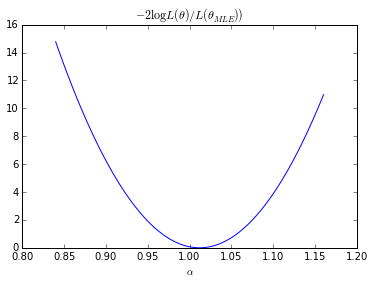

In [5]:
plt.plot(As, nll)
plt.xlabel(r"$\alpha$")
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
plt.show()

# Likelihood-free setup

In [6]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

clf_parameters = [(1000,100000),(1000000,500),(1000000,100000)]
#clf_parameters = [(1000000,1000000)]
X = [0]*3*3
y = [0]*3*3
#X = [0]*3
#y = [0]*3


for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    print param
    print p1
    X[k], y[k] = make_parameterized_classification(
        p0, p1,
        param[0], 
        [(A, np.linspace(bounds[0][0],bounds[0][1], num=30))],
        random_state=0)


(1000, 100000)
LinearTransform(A=array([[ 1.3123 ,  0.105  ,  0.48311, -0.32499, -0.26388],
       [ 0.105  ,  1.15833, -0.55865,  0.25276, -0.39791],
       [ 0.48311, -0.55865,  2.25875, -0.52088, -0.39271],
       [-0.32499,  0.25276, -0.52088,  1.40349, -0.63521],
       [-0.26388, -0.39791, -0.39271, -0.63521,  1.     ]]),
        p=Join(components=[Normal(mu=mu, sigma=sigma), Normal(mu=mu, sigma=sigma), Mixture(components=[Normal(mu=mu, sigma=sigma), Normal(mu=mu, sigma=sigma)],
    weights=[param_w0, Elemwise{sub,no_inplace}.0]), Exponential(inverse_scale=inverse_scale), Exponential(inverse_scale=inverse_scale)]))
(1000, 100000)
LinearTransform(A=array([[ 1.3123 ,  0.105  ,  0.48311, -0.32499, -0.26388],
       [ 0.105  ,  1.15833, -0.55865,  0.25276, -0.39791],
       [ 0.48311, -0.55865,  2.25875, -0.52088, -0.39271],
       [-0.32499,  0.25276, -0.52088,  1.40349, -0.63521],
       [-0.26388, -0.39791, -0.39271, -0.63521,  1.     ]]),
        p=Join(components=[Normal(mu=mu, 

In [7]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
clfs = []
for k,_ in enumerate(product(clf_parameters,p1s)):
    clfs.append(ParameterizedClassifier(
        make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
        [A]))
    clfs[k].fit(X[k], y[k])

/Users/juanpavez/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func,n_samples,clf,p1):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i,n_samples=n_samples,clf=clf, p1=p1)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, n_samples=100000, clf=clfs[0],p1=p1s[0]):    
    print(theta)
    
    # Set parameter values   
    A.set_value(theta[0])
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=n_samples)
    X1 = p1.rvs(n_samples=n_samples, random_state=random_state)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    
    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)    
            
    return value

In [9]:
from GPyOpt.methods import BayesianOptimization
solvers = []
for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    clf = clfs[k]
    n_samples = param[1]
    bounds = [(-3, 3)]
    solvers.append(BayesianOptimization(vectorize(objective,n_samples,clf,p1), bounds))
    solvers[k].run_optimization(max_iter=50, true_gradients=False)

[-0.65152321]
[ 0.34910881]
[-0.58025901]
[ 0.92850039]
[ 2.39477965]
[ 1.07976357]
[-3.]
[ 1.35467141]
[ 1.21146072]
[ 1.15190889]
[ 1.15247315]
[ 1.16283111]
[ 1.14797453]
[ 1.1795207]
[ 1.19140198]
[ 1.15612847]
[ 1.16778322]
[ 1.17173181]
[ 1.22210074]
[ 1.15840022]
[ 1.15515368]
[ 1.15837921]
[ 1.1765412]
[ 1.17502759]
[ 1.15758851]
[ 1.16985182]
[ 1.19715701]
[ 1.1409768]
[ 1.17399197]
[ 1.16349036]
[ 1.17347806]
[ 1.2048211]
[ 1.14995829]
[ 1.19875576]
[ 1.14436494]
[ 1.16445249]
[ 1.16323863]
[ 1.16194131]
[ 1.16190684]
[ 1.18353373]
[ 1.15387233]
[ 1.17800978]
[ 1.16413189]
[ 1.15204854]
[ 1.17589305]
[ 1.14614902]
[ 1.15760234]
[ 1.18409921]
[ 1.15600991]
[ 1.17557622]
[ 1.17483796]
[ 1.1486868]
[ 1.13532445]
*Optimization completed:
   -Maximum number of iterations reached.
[-1.56379072]
[-1.84997]
[-2.49716168]
[ 3.]
[ 0.65221064]
[ 0.32436238]
[ 0.86128395]
[ 0.9617598]
[ 0.89924396]
[ 0.91776412]
[ 0.88855603]
[ 0.90344626]
[ 0.96267856]
[ 0.93397397]
[ 0.93964445]
[ 1.00

In [10]:
approx_MLEs = []
for k,_ in enumerate(product(clf_parameters,p1s)):
    solver = solvers[k]
    approx_MLE = solver.x_opt
    approx_MLEs.append(approx_MLE)
    print("Approx. MLE =", approx_MLE)

('Approx. MLE =', array([ 1.16413189]))
('Approx. MLE =', array([ 0.94663727]))
('Approx. MLE =', array([ 1.27348808]))
('Approx. MLE =', array([ 1.1194096]))
('Approx. MLE =', array([ 1.00237073]))
('Approx. MLE =', array([ 0.89313656]))
('Approx. MLE =', array([ 1.01881375]))
('Approx. MLE =', array([ 0.99491305]))
('Approx. MLE =', array([ 1.03651775]))


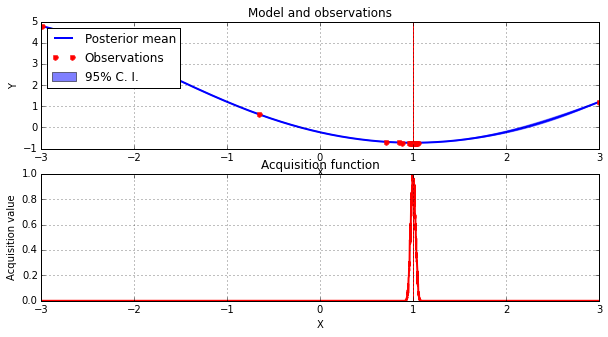

In [11]:
solver.plot_acquisition()

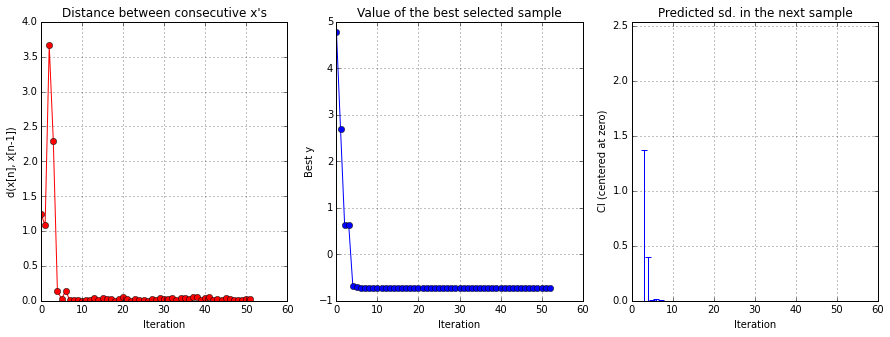

In [12]:
solver.plot_convergence()

In [13]:
# Minimize the surrogate GP approximate of the approximate LR
rs = []
solver = solvers[0]

for k,_ in enumerate(product(clf_parameters,p1s)):
    def gp_objective(theta):
        theta = theta.reshape(1, -1)
        return solvers[k].model.predict(theta)[0][0]

    r = minimize(gp_objective, x0=[0])
    rs.append(r)
    gp_MLE = r.x

    print("GP MLE =", gp_MLE)

('GP MLE =', array([ 1.16159462]))
('GP MLE =', array([ 0.97255977]))
('GP MLE =', array([ 1.26513891]))
('GP MLE =', array([ 1.11403158]))
('GP MLE =', array([ 0.98412237]))
('GP MLE =', array([ 0.87652996]))
('GP MLE =', array([ 1.00740701]))
('GP MLE =', array([ 0.9974838]))
('GP MLE =', array([ 1.00067007]))


In [14]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
approx_ratios = []
gp_ratios = []
gp_std = []
bounds = [(true_A - 0.16, true_A + 0.16)]
n_points = 30

As = np.linspace(bounds[0][0],bounds[0][1],100)

for k,(param,p1) in enumerate(product(clf_parameters,p1s)):
    clf = clfs[k]
    n_samples = param[1]
    solver = solvers[k]
    print n_samples
    #As = np.linspace(*bounds[0], 100)
    nll_gp, var_gp = solvers[k].model.predict(As.reshape(-1, 1))
    nll_gp = 2. * (nll_gp - rs[k].fun) * len(X_true)
    gp_ratios.append(nll_gp)
    std_gp = np.sqrt(var_gp)
    std_gp[np.isnan(std_gp)] = 0.
    gp_std.append(std_gp)
    #nll_approx = np.zeros(n_points)

    #approx = [objective([a]) for a in np.linspace(*bounds[0], n_points)]
    #approx = [objective([a],n_samples=n_samples,clf=clf,p1=p1) for a 
    #          in np.linspace(bounds[0][0],bounds[0][1], n_points)]

    #approx = np.array(approx)
    #approx = 2. * (approx - approx.min()) * len(X_true)
    #nll_approx = approx
    #approx_ratios.append(nll_approx)


100000
100000
100000
500
500
500
100000
100000
100000


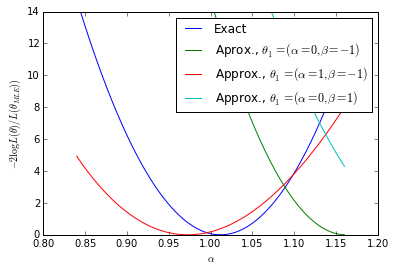

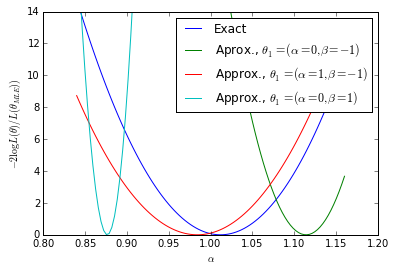

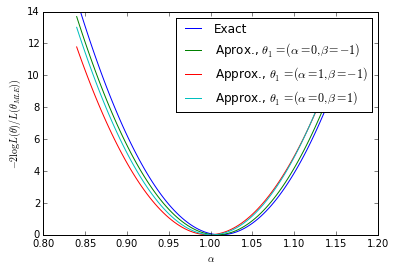

In [18]:
k = 0
#print gp_std[3*k]
for k,_ in enumerate(clf_parameters):
    #nll_approx = approx_ratios[k]
    #nll_gp = gp_ratios[k]
    plt.plot(As, nll, label="Exact")
    #plt.plot(np.linspace(*bounds[0], n_points), nll_approx - , label="approx.")
    #plt.plot(np.linspace(bounds[0][0],bounds[0][1], n_points), nll_approx , label="approx.")
    plt.plot(As, gp_ratios[3*k], label=r"Aprox., $\theta_1=(\alpha=0,\beta=-1)$")
    plt.plot(As, gp_ratios[3*k+1], label=r"Approx., $\theta_1=(\alpha=1,\beta=-1)$")
    #plt.fill_between(As,(gp_ratios[3*k]-gp_std[3*k]).ravel(),(gp_ratios[3*k]+gp_std[3*k]).ravel())
    plt.plot(As, gp_ratios[3*k+2], label=r"Approx., $\theta_1=(\alpha=0,\beta=1)$")

    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
    plt.legend()
    plt.ylim(0, 14)
    plt.savefig('likelihood_comp_{0}.pdf'.format(k))
    plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc
def makeROC(predictions,targetdata):
    fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc

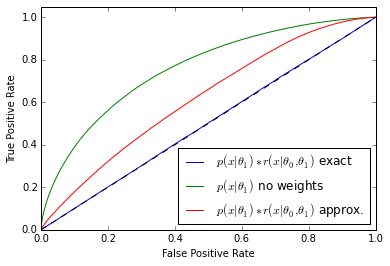

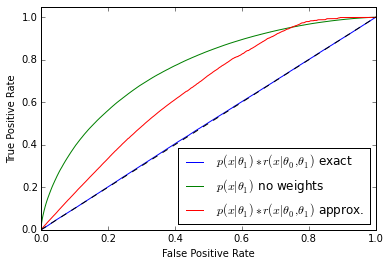

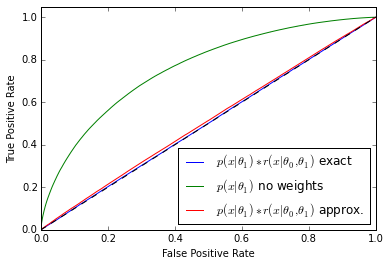

In [17]:
#fig = plt.figure(figsize=(15,15))
# I add this again in order to make the grid of plots
# Plotting the likelihood curves
'''
for k,_ in enumerate(clf_parameters):
    fig.add_subplot(3,2,k*2+1)
    #nll_approx = approx_ratios[k]
    #nll_gp = gp_ratios[k]
    plt.plot(As, nll, label="Exact")
    #plt.plot(np.linspace(*bounds[0], n_points), nll_approx - , label="approx.")
    #plt.plot(np.linspace(bounds[0][0],bounds[0][1], n_points), nll_approx , label="approx.")
    plt.plot(As, gp_ratios[3*k], label=r"Aprox., $\theta_1=(\alpha=0,\beta=-1)$")
    plt.plot(As, gp_ratios[3*k+1], label=r"Approx., $\theta_1=(\alpha=1,\beta=-1)$")
    plt.plot(As, gp_ratios[3*k+2], label=r"Approx., $\theta_1=(\alpha=0,\beta=1)$")

    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
    plt.legend()
    plt.ylim(0, 14)
A.set_value(true_A)
'''
# I obtain data from r*p1 by resampling data from p1 using r as weights
def weight_data(x0,x1,weights):
    x1_len = x1.shape[0]
    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x1_len), x1_len, p = weights)
    w_x1 = x1.copy()[weighted_data]
    y = np.zeros(x1_len * 2)
    x_all = np.vstack((w_x1,x0))
    y_all = np.zeros(x1_len * 2)
    y_all[x1_len:] = 1
    return (x_all,y_all)

p1 = p1s[0]
X0_roc = p0.rvs(500000)
X1_roc = p1.rvs(500000,random_state=777)

# Roc curve comparison for p0 - r*p1
for k,param in enumerate(clf_parameters):
    #fig.add_subplot(3,2,(k+1)*2)

    clf = clfs[3*k]
    n_samples = param[1]
    X0 = p0.rvs(n_samples)
    X1 = p1.rvs(n_samples,random_state=777)
    X_len = X1.shape[0]
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)

    # Weighted with true ratios
    true_r = p0.pdf(X1_roc) / p1.pdf(X1_roc)
    true_r[np.isinf(true_r)] = 0.
    true_weighted = weight_data(X0_roc,X1_roc,true_r)
    # Weighted with approximated ratios
    app_r = ratio.predict(X1_roc,log=False)
    app_r[np.isinf(app_r)] = 0.
    app_weighted = weight_data(X0_roc,X1_roc,app_r)

    clf_true = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)
    # Maybe I should use CV here?
    #fig = plt.figure()
    clf_true.fit(true_weighted[0],true_weighted[1])
    predicted_true = clf_true.predict(true_weighted[0])
    fpr_t,tpr_t,roc_auc_t = makeROC(predicted_true, true_weighted[1])
    plt.plot(fpr_t, tpr_t, label=r"$p(x|\theta_1)*r(x|\theta_0,\theta_1)$ exact" % roc_auc_t)

    clf_true.fit(np.vstack((X0_roc,X1_roc)),true_weighted[1])
    predicted_true = clf_true.predict(np.vstack((X0_roc,X1_roc)))
    fpr_f,tpr_f,roc_auc_f = makeROC(predicted_true, true_weighted[1])
    plt.plot(fpr_f, tpr_f, label=r"$p(x|\theta_1)$ no weights" % roc_auc_f)

    clf_true.fit(app_weighted[0],app_weighted[1])
    predicted_true = clf_true.predict(app_weighted[0])
    fpr_a,tpr_a,roc_auc_a = makeROC(predicted_true, app_weighted[1])
    plt.plot(fpr_a, tpr_a, label=r"$p(x|\theta_1)*r(x|\theta_0,\theta_1)$ approx." % roc_auc_a)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('{0} n_epochs {1}'.format('ROC',epochs_training))
    plt.legend(loc="lower right")
    plt.savefig('ROC_comp{0}.pdf'.format(k))
    plt.show()

#plt.savefig('all_comp.pdf'.format(k))